# Image Duplicates & Near Duplicates

This example shows how SentenceTransformers can be used to find image duplicates and near duplicats.

As model, we use the [OpenAI CLIP Model](https://github.com/openai/CLIP), which was trained on a large set of images and image alt texts.

As a source for fotos, we use the [Unsplash Dataset Lite](https://unsplash.com/data), which contains about 25k images. See the [License](https://unsplash.com/license) about the Unsplash images. 

We encode all images into vector space and then find high density regions in this vector space, i.e., regions where the images are fairly similar.

In [1]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

#First, we load the CLIP model
model = SentenceTransformer('clip-ViT-B-32')

In [2]:
# Next, we get about 25k images from Unsplash 
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)
        

In [3]:
# Now, we need to compute the embeddings
# To speed things up, we destribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))

use_precomputed_embeddings = True

if use_precomputed_embeddings: 
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)
        
    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)  
    print("Images:", len(img_names))
else:
    img_names = list(glob.glob('unsplash/photos/*.jpg'))
    print("Images:", len(img_names))
    img_emb = model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)


Images: 24996


In [4]:
# Now we run the clustering algorithm
# With the threshold parameter, we define at which threshold we identify
# two images as similar. Set the threshold lower, and you will get larger clusters which have 
# less similar images in it (e.g. black cat images vs. cat images vs. animal images).
# With min_community_size, we define that we only want to have clusters of a certain minimal size

duplicates = util.paraphrase_mining_embeddings(img_emb)

# duplicates contains a list with triplets (score, image_id1, image_id2) and is scorted in decreasing order

## Duplicates
In the next cell, we output the top 10 most similar images. These are identical images,
i.e. the same photo was uploaded twice to Unsplash


Score: 1.000
0UtMDLOk0Vg.jpg


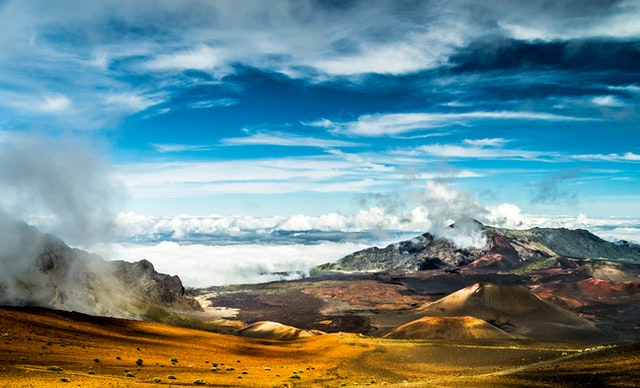

10OY7Od4YeQ.jpg


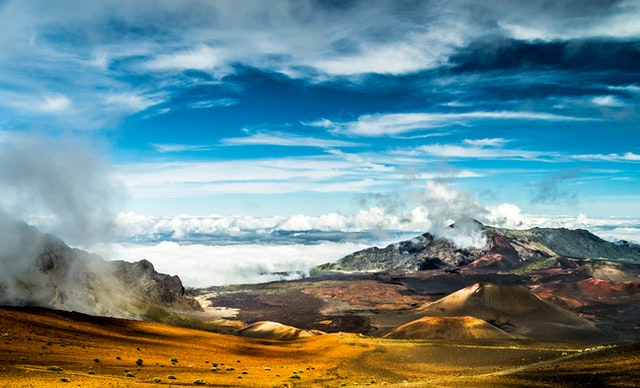


Score: 1.000
QO4Y97jiVDQ.jpg


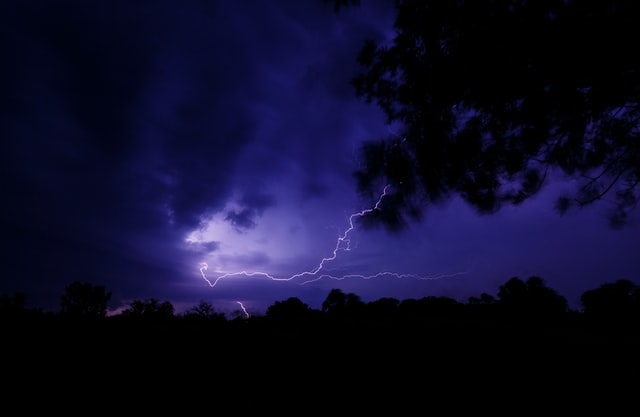

0ETSZYPjvDo.jpg


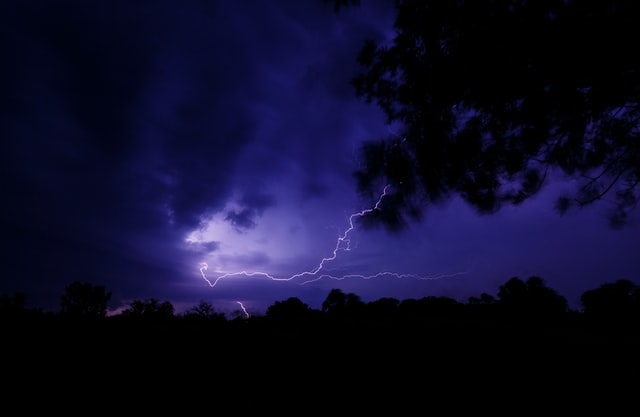


Score: 1.000
fPipNm8A5uc.jpg


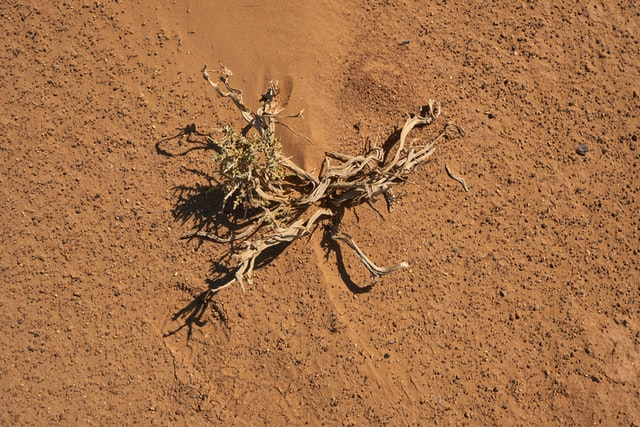

cSSWEsnYv7w.jpg


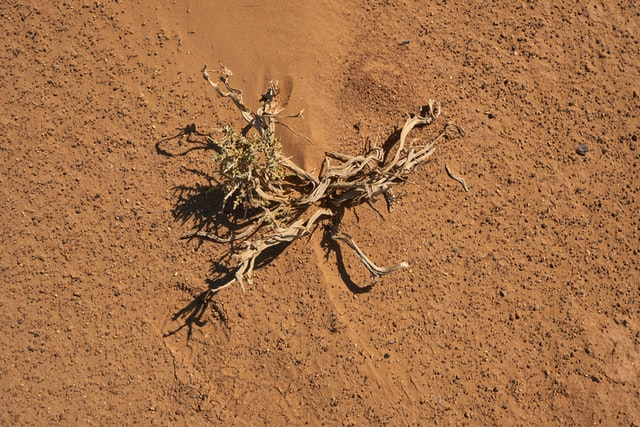


Score: 1.000
xm6esles7ds.jpg


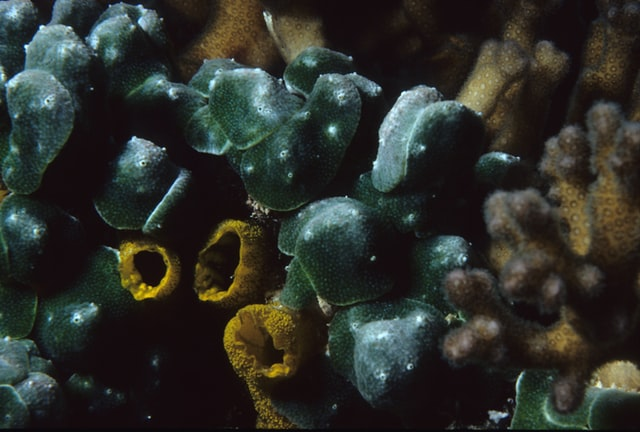

CkwM5Mrnd8U.jpg


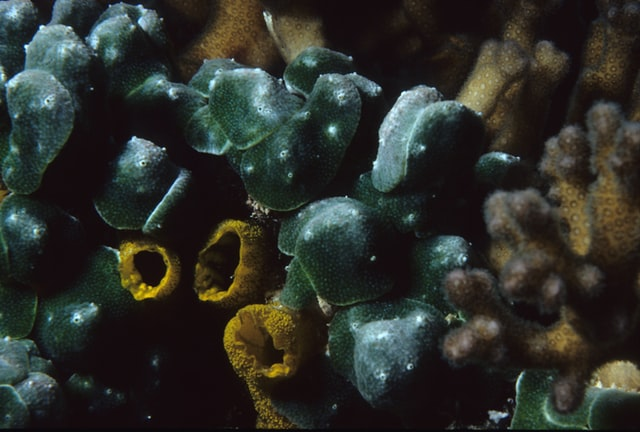


Score: 1.000
4f4e3hRnwKs.jpg


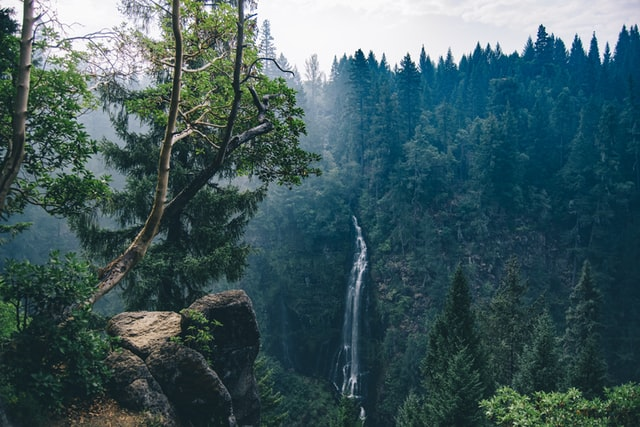

f3hDGOHptrM.jpg


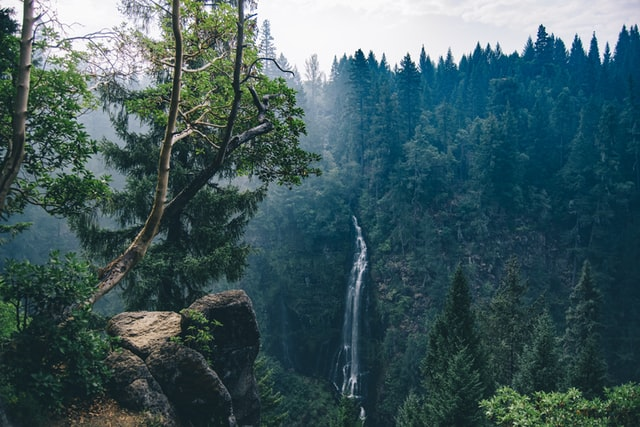


Score: 1.000
LYycu62H2-8.jpg


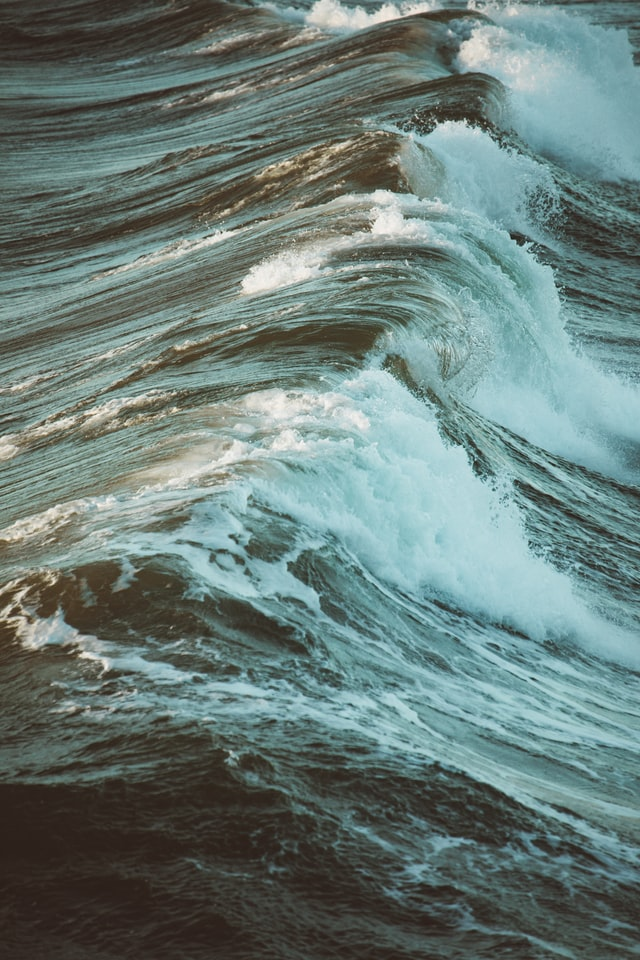

s5_rlPwwads.jpg


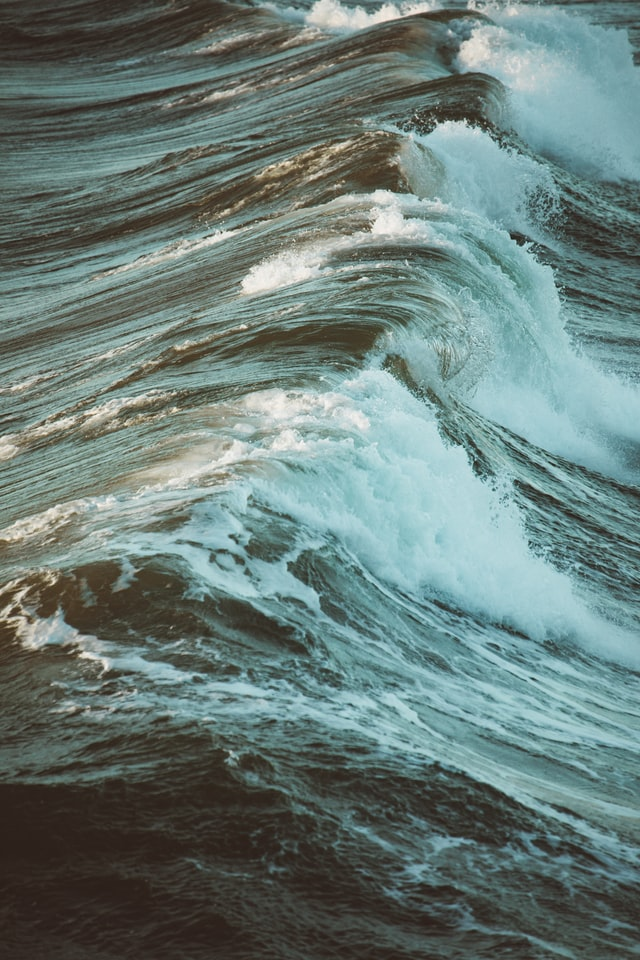


Score: 1.000
RadJczno8RA.jpg


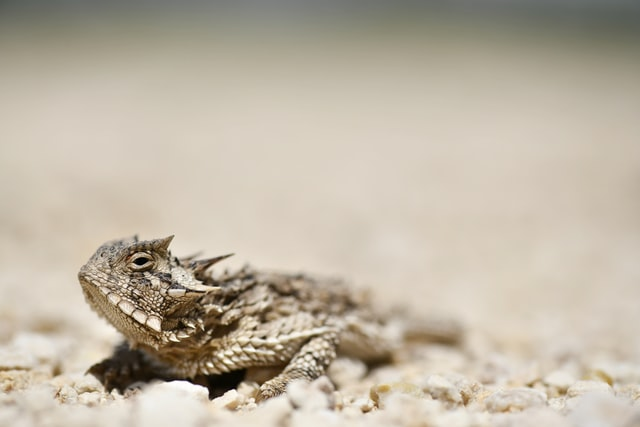

fmTDdLOEkl0.jpg


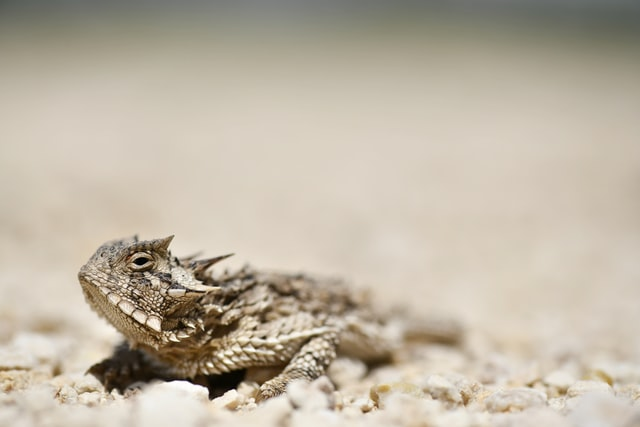


Score: 1.000
6VBgzF3H64c.jpg


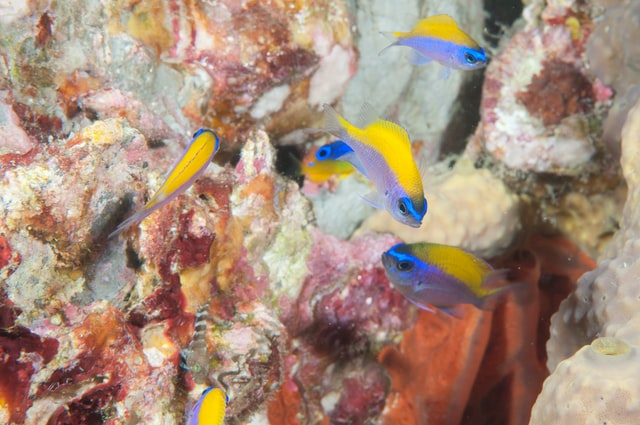

mSL1shtsWFU.jpg


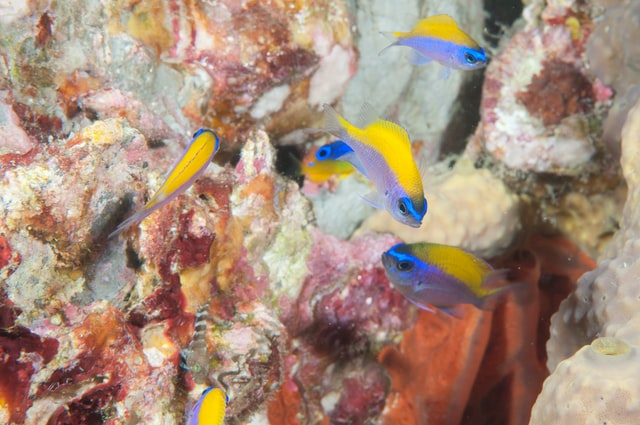


Score: 1.000
PySq7yX6hlw.jpg


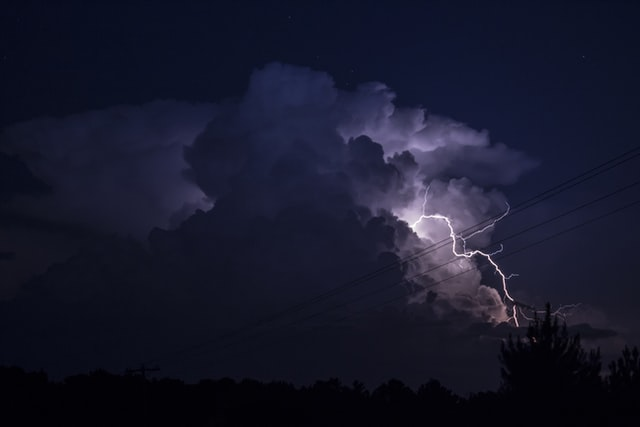

JG_HfydoNqY.jpg


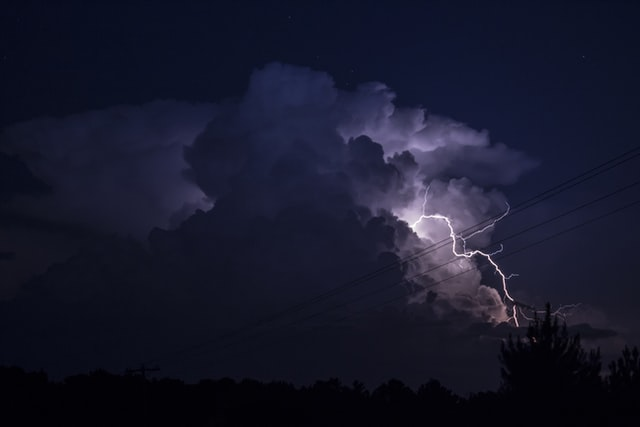


Score: 1.000
Aq3NQwdqOU8.jpg


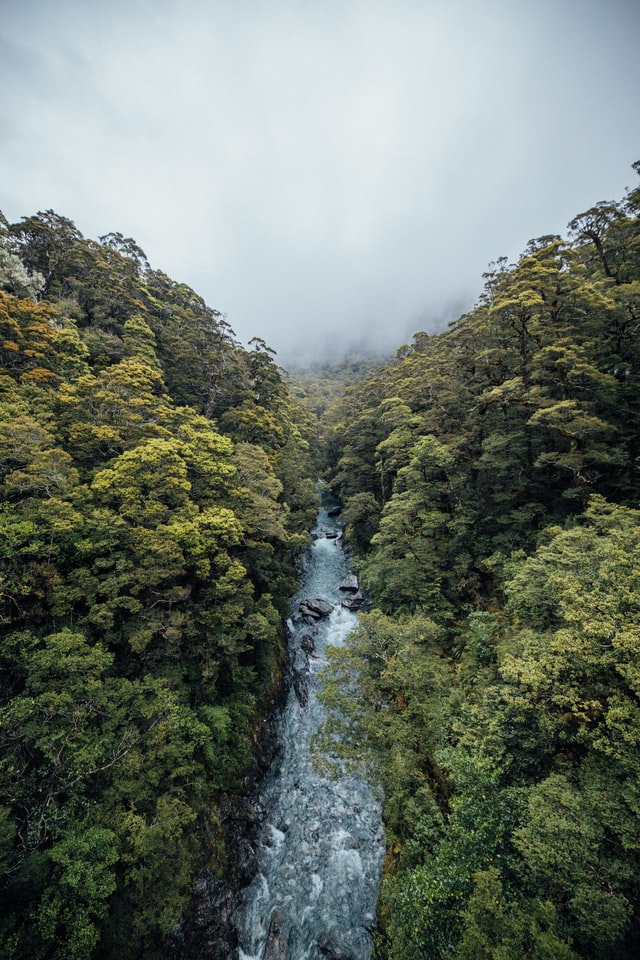

JO_6maFFeoQ.jpg


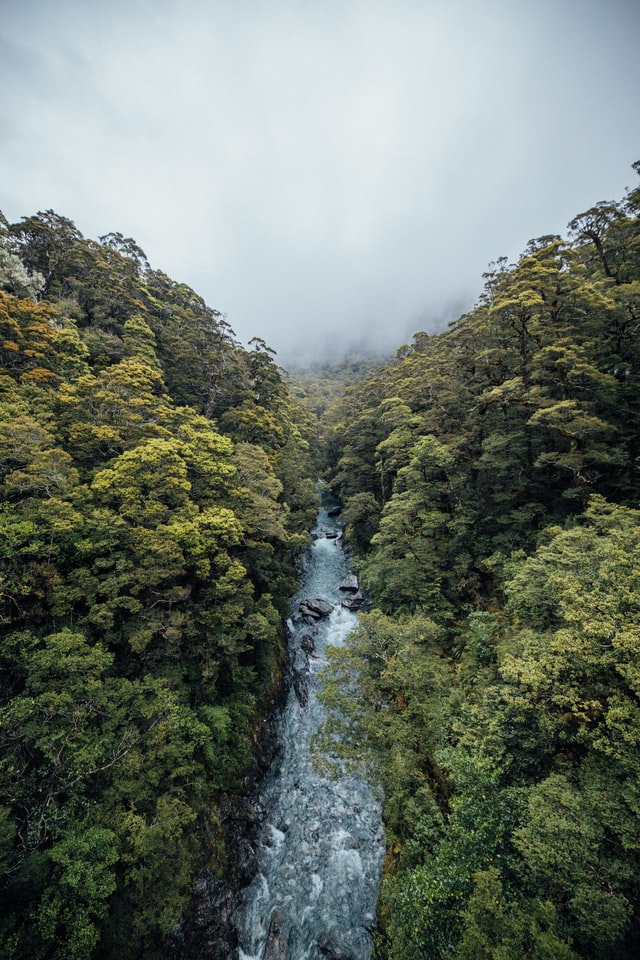

In [7]:
for score, idx1, idx2 in duplicates[0:10]:
    print("\nScore: {:.3f}".format(score))
    print(img_names[idx1])
    display(IPImage(os.path.join(img_folder, img_names[idx1]), width=200))
    print( img_names[idx2])
    display(IPImage(os.path.join(img_folder, img_names[idx2]), width=200))

## Near Duplicates
We can also skip the duplicate images and find near duplicates.
To achieve this, we only look at images pairs that have a cosine similarity below a certain threshold.
In our example, we look at images with a cosine similarity lower than 0.99


Score: 0.989
ht07CBODJVY.jpg


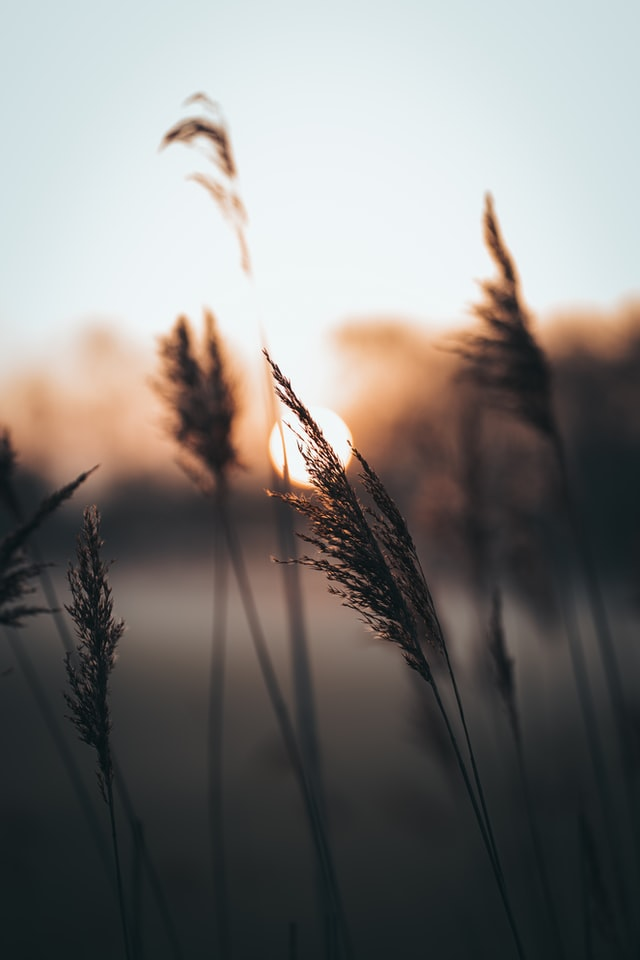

TVpMXc3Urzg.jpg


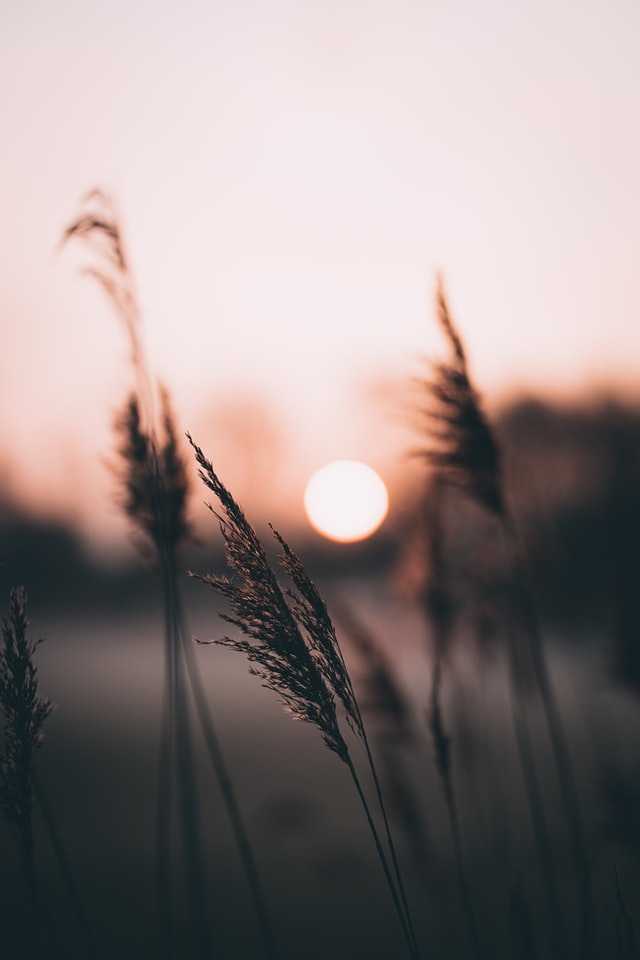


Score: 0.989
mOLet_-xn2M.jpg


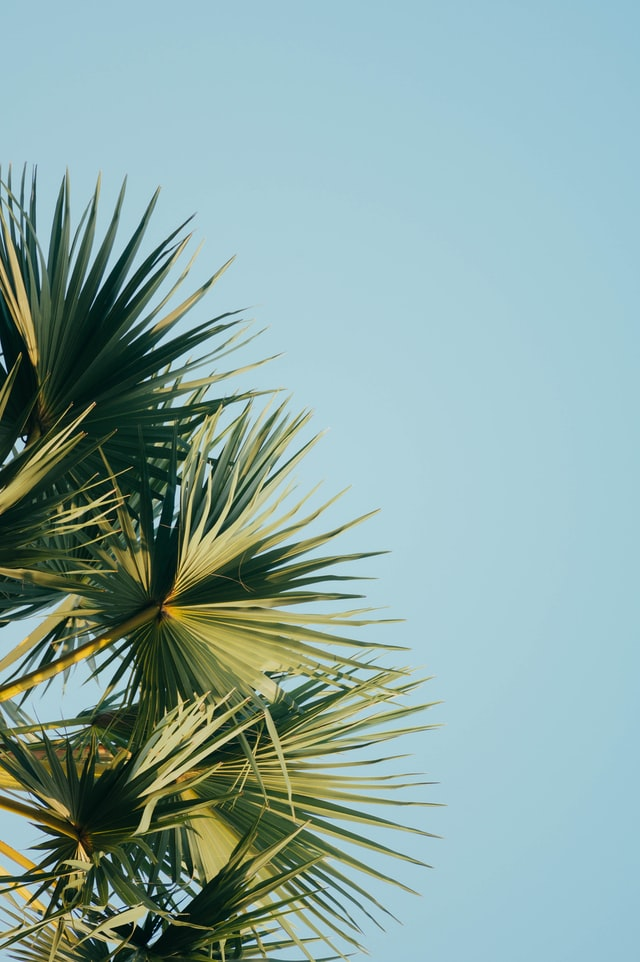

-zEDq4sRxRE.jpg


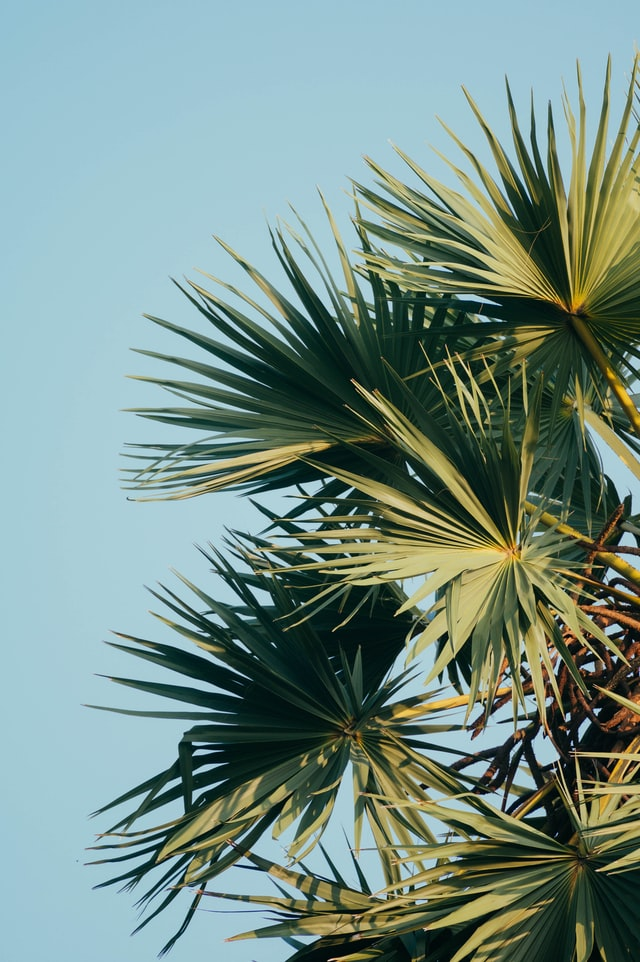


Score: 0.989
474zbfqYDIA.jpg


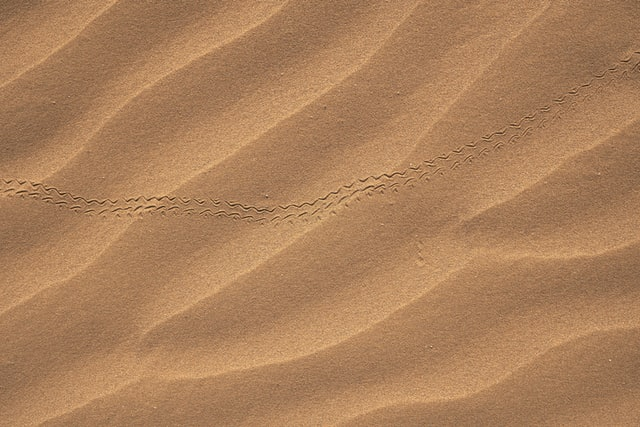

dSB_QwlCpRs.jpg


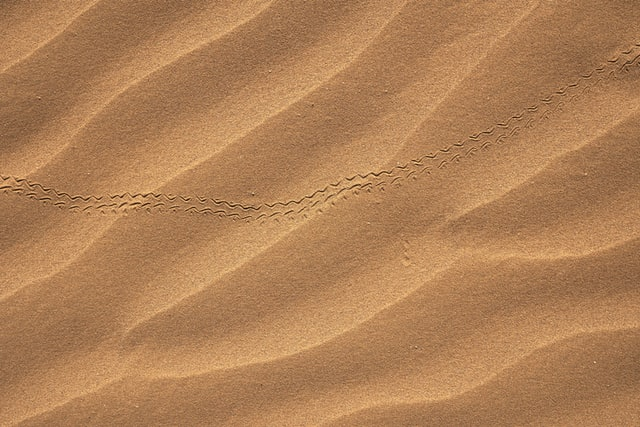


Score: 0.988
2yqsIIFSN-Y.jpg


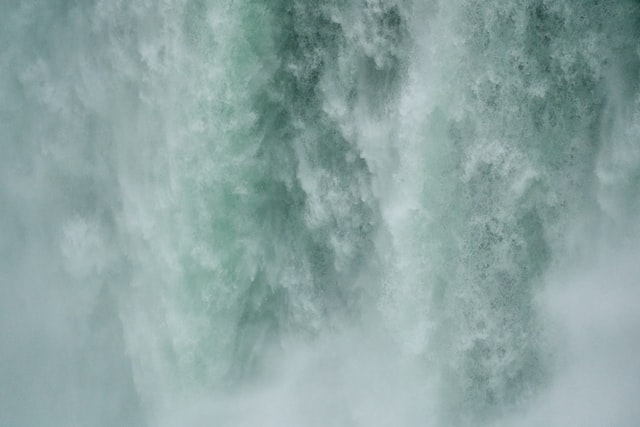

qcmhNEipNl0.jpg


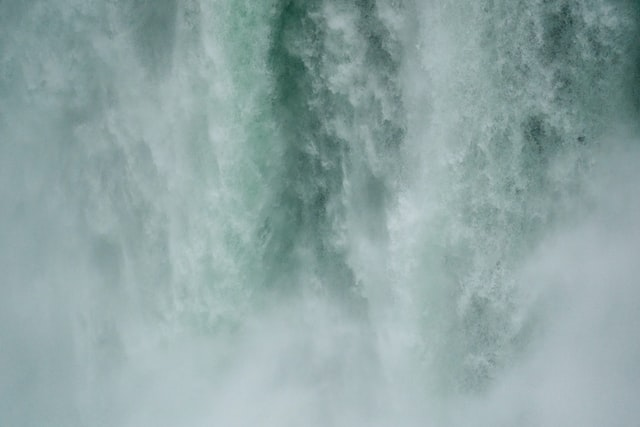


Score: 0.988
xjM0j6qBPGM.jpg


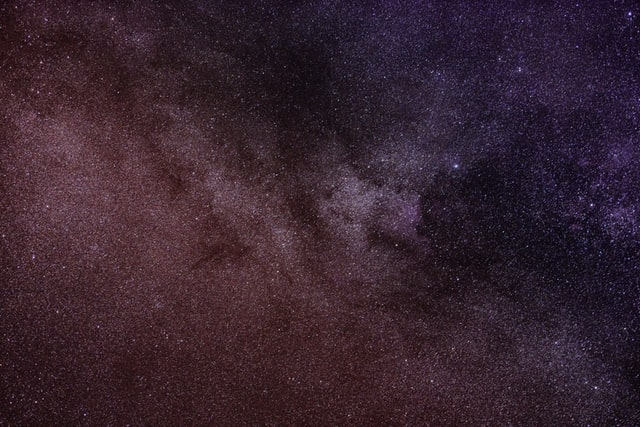

eS7HrvG0mcA.jpg


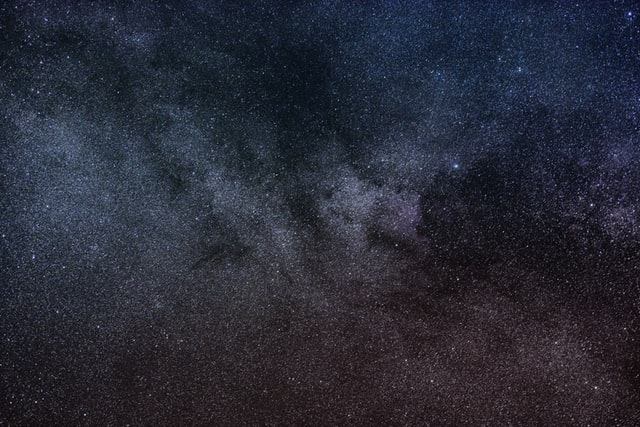


Score: 0.988
IXO5G1jR4h4.jpg


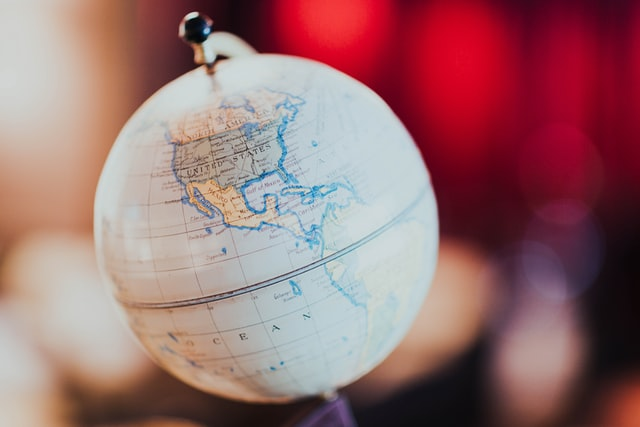

EheKbIZ8oAw.jpg


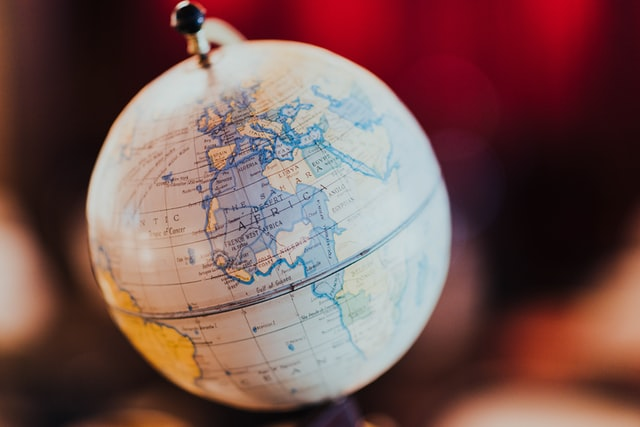


Score: 0.988
SKf6puU2BV8.jpg


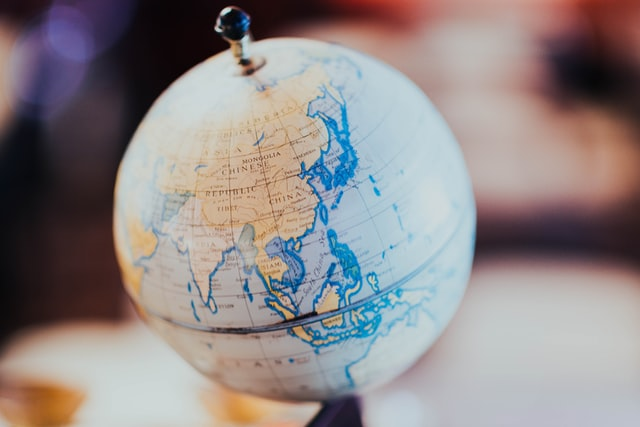

IXO5G1jR4h4.jpg


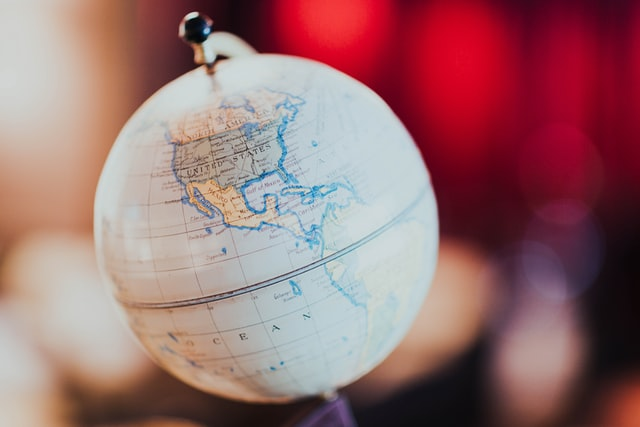


Score: 0.987
LdhDmizaN7k.jpg


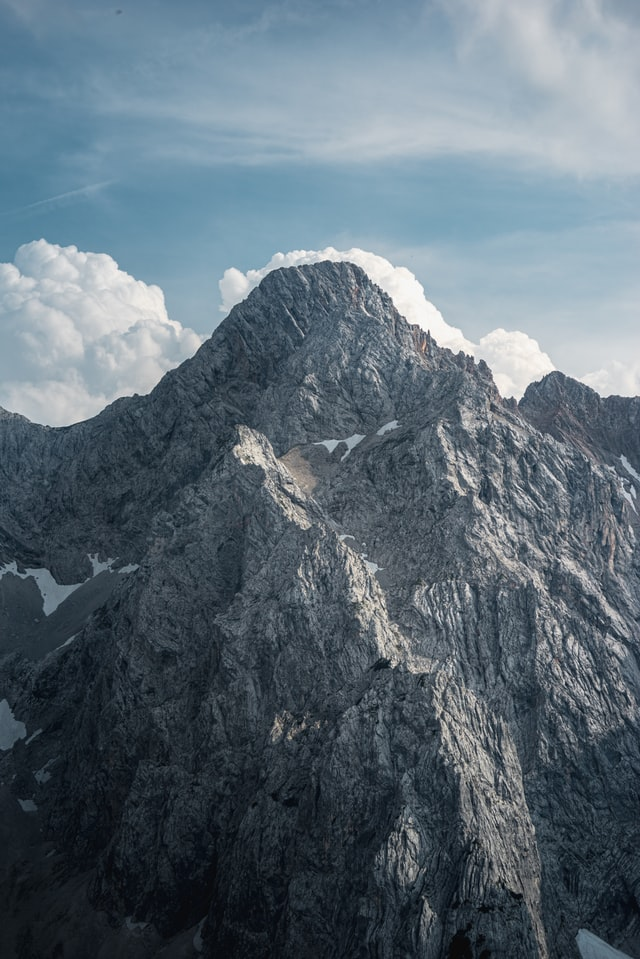

1VO4qqSvxfA.jpg


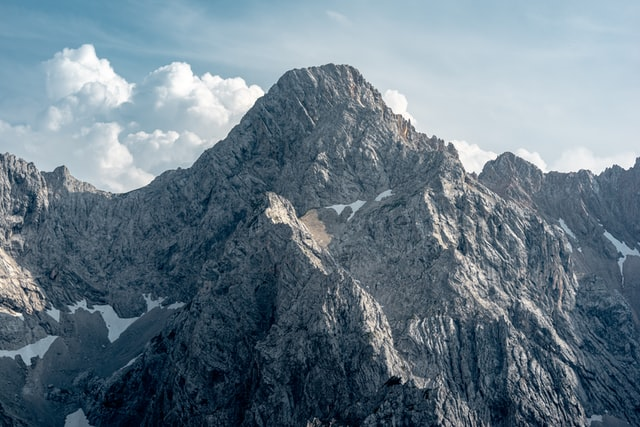


Score: 0.987
wH3POmZAsio.jpg


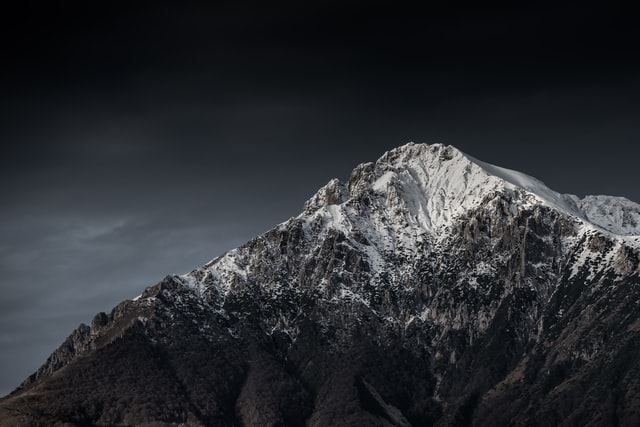

8jeWeKdygfk.jpg


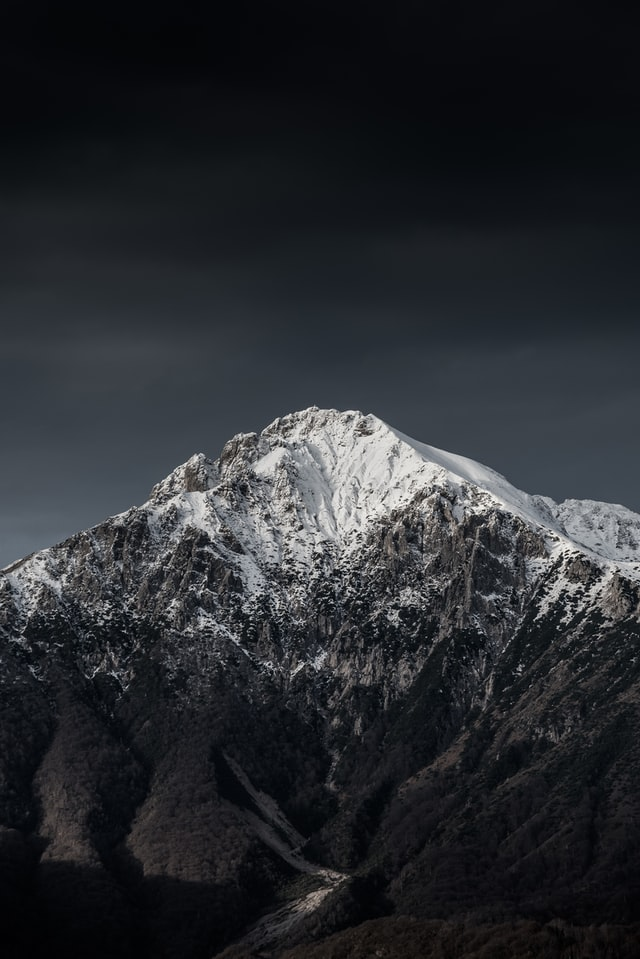


Score: 0.986
up_IHPsJvSI.jpg


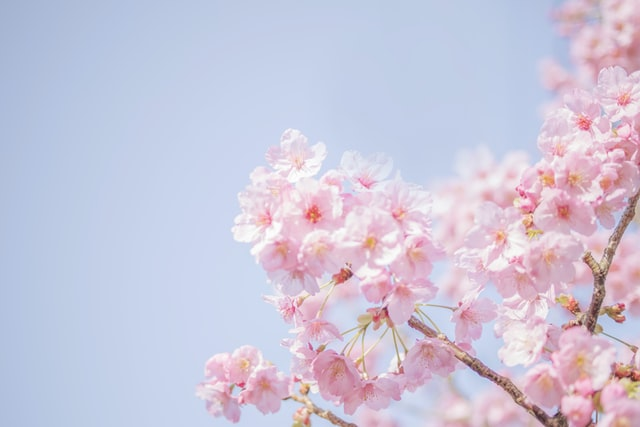

zlCAI1SWZ5M.jpg


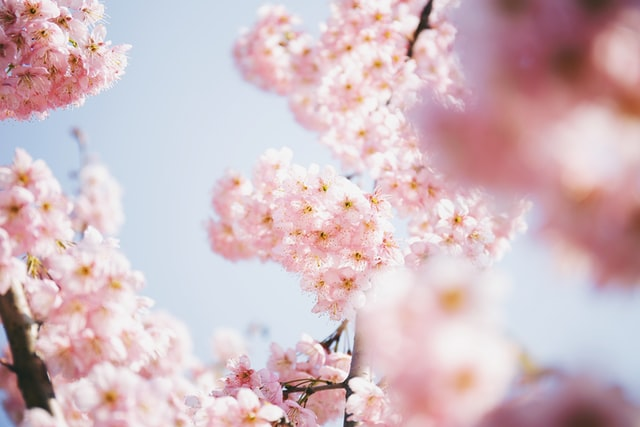

In [9]:
threshold = 0.99
near_duplicates = [entry for entry in duplicates if entry[0] < threshold]

for score, idx1, idx2 in near_duplicates[0:10]:
    print("\nScore: {:.3f}".format(score))
    print(img_names[idx1])
    display(IPImage(os.path.join(img_folder, img_names[idx1]), width=200))
    print(img_names[idx2])
    display(IPImage(os.path.join(img_folder, img_names[idx2]), width=200))
    